In [1]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [2]:
from sklearn.preprocessing import normalize
X_train = X_train / 255.0
X_test = X_test / 255.0
## bring the values to 0 to 1

In [3]:
import random
import matplotlib.pyplot as plt
def create_pairs_on_set(ds, lb):
  digitInd = [np.where(i == lb)[0] for i in range(0, 10)]
  pairs, labels = create_pairs(ds, digitInd)
  return pairs, labels.astype('float32')
def create_pairs(x, digit_indices):
  n = min([len(digit_indices[d]) for d in range(10)])-1
  pairs = []
  labels = []
  for d in range(10):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, 10)
      dn = (inc+d)%10
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1, 0]
  return np.array(pairs), np.array(labels)
def show_image_pair(pair, label):
  fig, ax = plt.subplots(2, 1)
  ax[0].imshow(pair[0, :, :])
  ax[0].set_title(np.where(int(label) == 0, 'Not Same', 'Same'))
  ax[0].axis(False)
  ax[1].imshow(pair[1, :, :])
  ax[1].axis(False)
  plt.show()

In [4]:
train_pairs, train_labels = create_pairs_on_set(X_train, Y_train)
test_pairs, test_labels = create_pairs_on_set(X_test, Y_test)

In [5]:
from tensorflow.keras import backend as K
def euclidean_distance(vects):
  '''
  Calculate euclidean between two vectors
  http://mathonline.wikidot.com/the-distance-between-two-vectors
  '''
  x, y = vects
  sum_squares = K.sum(K.square(x-y), axis=1, keepdims=True)
  # K.epsilon() = 1e-07 -> prevent number goes to small
  return K.sqrt(K.maximum(sum_squares, K.epsilon()))

def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

In [6]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
def base_network():
  _input = Input(shape = (28, 28), name = 'base_input')
  flattenInput = Flatten()(_input)
  dense_1 = Dense(128, activation = 'relu')(flattenInput)
  dropout_1 = Dropout(0.1, name = 'first_dropout')(dense_1)
  dense_2 = Dense(128, activation = 'relu')(dropout_1)
  dropout_2 = Dropout(0.1, name = 'second_dropout')(dense_2)
  dense_3 = Dense(128, activation = 'relu')(dropout_2)

  return Model(inputs = _input, outputs = dense_3)


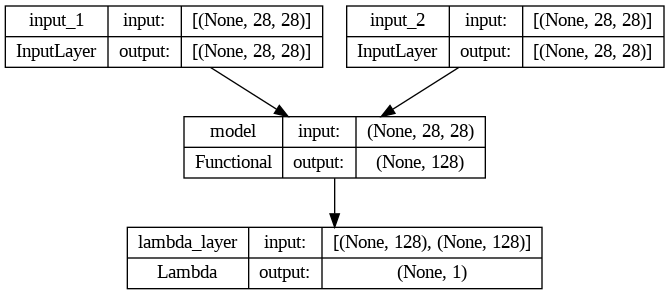

In [7]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Lambda
input_1 = Input(shape = (28, 28))
input_2 = Input(shape = (28, 28))
_base_network = base_network()
output_1 = _base_network(input_1)
output_2 = _base_network(input_2)
output = Lambda(function = euclidean_distance, output_shape = eucl_dist_output_shape, name='lambda_layer')([output_1, output_2])
model = Model(inputs=[input_1, input_2], outputs = output)
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [8]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin-y_pred, 0))
    return ((1 - y_true) * margin_square + y_true * square_pred)
  return contrastive_loss

In [9]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer = RMSprop(), loss = contrastive_loss_with_margin(margin = 1))
history = model.fit(
    x = [train_pairs[:, 0], train_pairs[:, 1]],
    y = train_labels,
    batch_size = 32,
    epochs=20,
    validation_data = ([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
)

Epoch 1/20
3750/3750 [==============================] - 17s 4ms/step - loss: 0.1056 - val_loss: 0.0834
Epoch 2/20
3750/3750 [==============================] - 14s 4ms/step - loss: 0.0806 - val_loss: 0.0766
Epoch 3/20
3750/3750 [==============================] - 14s 4ms/step - loss: 0.0748 - val_loss: 0.0735
Epoch 4/20
3750/3750 [==============================] - 14s 4ms/step - loss: 0.0716 - val_loss: 0.0719
Epoch 5/20
3750/3750 [==============================] - 14s 4ms/step - loss: 0.0699 - val_loss: 0.0752
Epoch 6/20
3750/3750 [==============================] - 14s 4ms/step - loss: 0.0687 - val_loss: 0.0708
Epoch 7/20
3750/3750 [==============================] - 14s 4ms/step - loss: 0.0674 - val_loss: 0.0723
Epoch 8/20
3750/3750 [==============================] - 14s 4ms/step - loss: 0.0666 - val_loss: 0.0680
Epoch 9/20
3750/3750 [==============================] - 14s 4ms/step - loss: 0.0660 - val_loss: 0.0693
Epoch 10/20
3750/3750 [==============================] - 14s 4ms/step - l

In [29]:
loss = model.evaluate(x = [test_pairs[:, 0], test_pairs[:, 1]], y = test_labels)

training = model.predict(x = [train_pairs[:, 0], train_pairs[:, 1]])
testing = model.predict(x = [test_pairs[:, 0], test_pairs[:, 1]])

625/625 [==============================] - 1s 2ms/step


In [30]:
def compute_accuracy(y_true, y_pred):
  pred = y_pred.ravel() < 0.5
  return np.mean(pred==y_true)

In [31]:
training_accuracy = compute_accuracy(train_labels, training)
testing_accuracy = compute_accuracy(test_labels, testing)
print(loss, training_accuracy, testing_accuracy)

0.06857482343912125 0.9309134855809301 0.9086586586586587


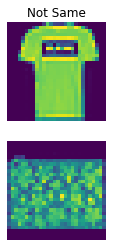

In [33]:
show_image_pair(train_pairs[1], train_labels[1])